In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import seml.database as db_utils
from pathlib import Path

import torch

from itertools import product

from statsmodels.stats.proportion import proportion_confint

import pandas as pd

import os

import sys
sys.path.append('../..')
from utils import load_results, plot_results_dict

In [2]:
collection = 'equivariance_structure_jin_proper_seeds'


jk_config = {
    'username': 'your-username',
    'password': 'your-password',
    'host': 'your-host-address',
    'port': 27017,
    'db_name': 'your-dbname'
}

col = db_utils.get_collection(collection, mongodb_config=jk_config)

In [3]:
def get_experiments(col, restrictions={}):
    
    restrictions['status'] = 'COMPLETED'

    if col.count_documents(restrictions) == 0:
        raise ValueError('No matches!')

    exps = col.find(restrictions, {'config':1, 'result': 1, '_id': 1})
    
    return exps

In [4]:
def get_certificates(raw_results_file):
    raw_results = torch.load(raw_results_file)

    certified = raw_results['certified_masks']
    predictions = raw_results['predictions']
    targets = [int(x) for x in raw_results['targets']]
    correct = np.array(targets) == np.array(predictions)
    accuracy = correct.mean()

    certified_ratios = certified.mean(axis=1)
    certified_ratios = np.insert(certified_ratios, 0, 1)

    certified_accuracies = (correct[None, :] & certified).mean(axis=1)
    certified_accuracies = np.insert(certified_accuracies, 0, accuracy)

    return {
        'predictions': predictions,
        'certified_ratios': certified_ratios,
        'targets': targets,
        'certified_accuracies': certified_accuracies
    }

In [5]:
def generate_exp_result_dict(exp):

    result_dict = {}

    result_dict['seed'] = exp['config']['seed']

    result_dict['dataset'] = exp['config']['dataset_params']['name']
    result_dict['hidden_sizes'] = exp['config']['dim_hidden']
    
    result_dict['max_degree'] = exp['config']['certification_params']['max_degree']

    result_dict['local_strength'] = exp['config']['certification_params']['local_strength']
    
    result_dict['cost_add'] = exp['config']['certification_params']['cost_add']
    result_dict['cost_del'] = exp['config']['certification_params']['cost_del']
    

    save_dir = exp['config']['save_dir']
    db_collection = exp['config']['db_collection']
    run_id = exp['_id']
    save_file = f'{save_dir}/{db_collection}_{run_id}'

    result_dict['raw_results_file'] = save_file

    cert_dict = get_certificates(result_dict['raw_results_file'])

    result_dict.update(cert_dict)

    return result_dict

In [6]:
# Use commented out code if you want to use your own data
#experiments = get_experiments(col)
#results = load_results(
#            generate_exp_result_dict,
#            experiments,
#            results_file='./raw_data',
#            overwrite=True
#            )


results = load_results(
            generate_exp_result_dict,
            None,
            results_file='./raw_data',
            overwrite=False
            )


In [7]:
results = results.replace({np.nan: None})
results

,seed,dataset,hidden_sizes,max_degree,local_strength,cost_add,cost_del,raw_results_file,predictions,certified_ratios,targets,certified_accuracies
0,0,MUTAG,64,None,3,1,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...","[1.0, 0.7040816326530612, 0.35714285714285715,...","[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...","[0.6836734693877551, 0.5612244897959183, 0.306..."
1,0,MUTAG,64,None,3,2,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...","[1.0, 0.8163265306122449, 0.5816326530612245, ...","[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...","[0.6836734693877551, 0.5918367346938775, 0.469..."
2,0,MUTAG,64,None,3,4,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...","[1.0, 0.8673469387755102, 0.673469387755102, 0...","[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...","[0.6836734693877551, 0.6224489795918368, 0.530..."
3,1,MUTAG,64,None,3,1,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.9591836734693877, 0.7857142857142857, ...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0.7040816326530612, 0.6938775510204082, 0.632..."
4,1,MUTAG,64,None,3,2,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.9693877551020408, 0.9387755102040817, ...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0.7040816326530612, 0.6938775510204082, 0.693..."
...,...,...,...,...,...,...,...,...,...,...,...,...
69,3,ENZYMES,64,None,3,1,4,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[4, 4, 1, 4, 1, 1, 1, 1, 4, 3, 4, 4, 1, 4, 2, ...","[1.0, 0.7933333333333333, 0.6566666666666666, ...","[2, 2, 0, 3, 1, 1, 0, 0, 2, 3, 3, 3, 0, 5, 1, ...","[0.29333333333333333, 0.2633333333333333, 0.22..."
70,4,PROTEINS,64,None,3,1,2,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1.0, 0.9623655913978495, 0.899641577060932, 0...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0.7204301075268817, 0.6971326164874552, 0.668..."
71,4,PROTEINS,64,None,3,1,4,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1.0, 0.96415770609319, 0.9121863799283154, 0....","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0.7204301075268817, 0.6989247311827957, 0.672..."
72,4,ENZYMES,64,None,3,1,2,/nfs/staff-hdd/schuchaj/equivariance_certifica...,"[1, 1, 1, 0, 4, 4, 4, 0, 2, 2, 2, 0, 4, 4, 1, ...","[1.0, 0.64, 0.49333333333333335, 0.46666666666...","[2, 0, 1, 5, 5, 3, 3, 0, 0, 2, 0, 4, 2, 4, 1, ...","[0.2633333333333333, 0.19333333333333333, 0.16..."


In [8]:
def prepare_plot_dict(res, cost_add=True):
    plot_dict = {}

    cost_key = 'cost_add' if cost_add else 'cost_del'

    print(f'Preparing {len(res)} results.')

    for i in range(len(res)):
        row = res.iloc[i]

        cost = row[cost_key]

        if str(cost) not in plot_dict:
            plot_dict[str(cost)] = {
                'cert_metrics': [row['certified_accuracies']]
            }
        
        else:
            plot_dict[str(cost)]['cert_metrics'].append(row['certified_accuracies'])

    for cost in plot_dict:
        num_budget_steps = 200
        plot_dict[cost]['budgets'] = np.arange(num_budget_steps)

        num_seeds = len(plot_dict[cost]['cert_metrics'])
        padded_metrics = np.zeros((num_seeds, num_budget_steps))

        for i, m in enumerate(plot_dict[cost]['cert_metrics']):
            padded_metrics[i, :len(m)] = m

        plot_dict[cost]['cert_metrics'] = padded_metrics.mean(axis=0)
        plot_dict[cost]['errors'] = padded_metrics.std(axis=0) * 1

    return plot_dict

Preparing 15 results.
Max error for 1 is 0.19216212091972806
Max error for 2 is 0.22331790597791829
Max error for 4 is 0.19960393936847015


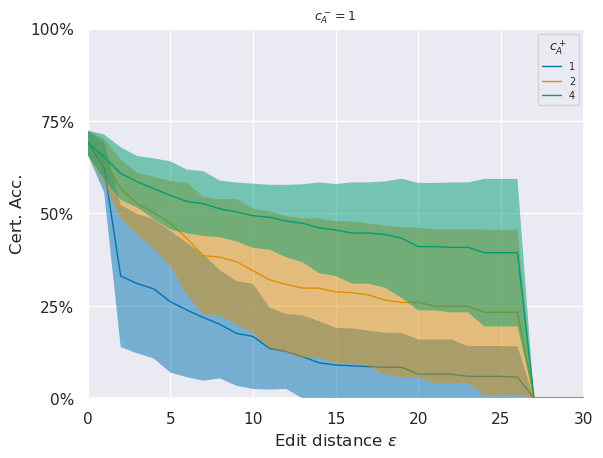

In [9]:
dataset = 'MUTAG'
res = results.loc[(results['dataset'] == dataset) & (results['local_strength'] == 3) & (results['cost_del'] == 1) & (results['cost_add'] != 3)]
d = prepare_plot_dict(res, cost_add=True)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_A^+$'}, ylim=1, xlim=30, clip_on=True,
                title_params={'label': '$c_A^-=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']})


Preparing 15 results.
Max error for 1 is 0.19216212091972806
Max error for 2 is 0.1869325371029304
Max error for 4 is 0.18608395591926313


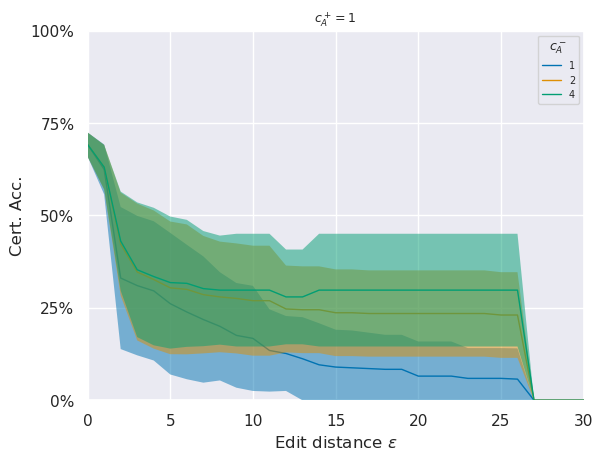

In [10]:
dataset = 'MUTAG'
res = results.loc[(results['dataset'] == dataset) & (results['local_strength'] == 3) & (results['cost_add'] == 1) & (results['cost_del'] != 3)]
d = prepare_plot_dict(res, cost_add=False)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_A^-$'}, ylim=1, xlim=30, clip_on=True,
                title_params={'label': '$c_A^+=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']})


Preparing 15 results.
Max error for 1 is 0.05185873355607524
Max error for 2 is 0.04030624918176116
Max error for 4 is 0.04062056363156186


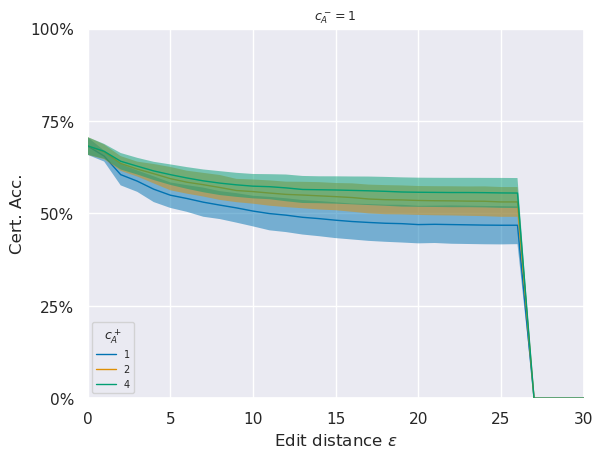

In [11]:
dataset = 'PROTEINS'
res = results.loc[(results['dataset'] == dataset) & (results['local_strength'] == 3) & (results['cost_del'] == 1) & (results['cost_add'] != 3)]
d = prepare_plot_dict(res, cost_add=True)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_A^+$', 'loc': 'lower left'}, ylim=1, xlim=30, clip_on=True,
                title_params={'label': '$c_A^-=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']})


In [12]:
d['4']['cert_metrics'][25]

0.5555555555555556

Preparing 15 results.
Max error for 1 is 0.05185873355607524
Max error for 2 is 0.026591020775614937
Max error for 4 is 0.023936642088980643


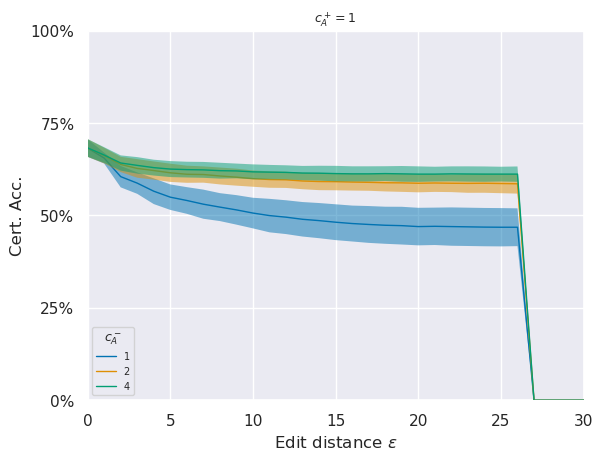

In [13]:
dataset = 'PROTEINS'
res = results.loc[(results['dataset'] == dataset) & (results['local_strength'] == 3) & (results['cost_add'] == 1) & (results['cost_del'] != 3)]
d = prepare_plot_dict(res, cost_add=False)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_A^-$', 'loc': 'lower left'}, ylim=1, xlim=30, clip_on=True,
                title_params={'label': '$c_A^+=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']})


In [14]:
d['4']['cert_metrics'][25]

0.6118279569892472

Preparing 14 results.
Max error for 2 is 0.029619813188697414
Max error for 4 is 0.026948510575210315
Max error for 1 is 0.031213868000546742


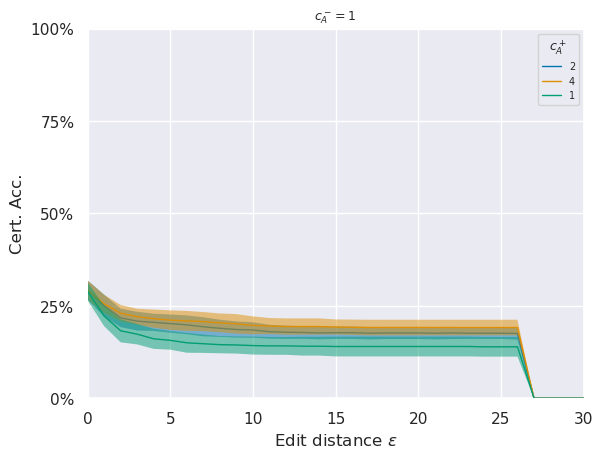

In [15]:
dataset = 'ENZYMES'
res = results.loc[(results['dataset'] == dataset) & (results['local_strength'] == 3) & (results['cost_del'] == 1) & (results['cost_add'] != 3)]
d = prepare_plot_dict(res, cost_add=True)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_A^+$'}, ylim=1, xlim=30, clip_on=True,
                title_params={'label': '$c_A^-=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']})

Preparing 14 results.
Max error for 1 is 0.031213868000546742
Max error for 2 is 0.027856776554368235
Max error for 4 is 0.029544693074880442


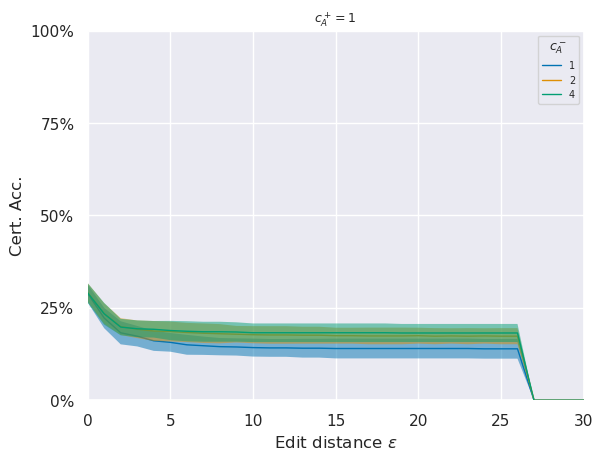

In [16]:
dataset = 'ENZYMES'
res = results.loc[(results['dataset'] == dataset) & (results['local_strength'] == 3) & (results['cost_add'] == 1) & (results['cost_del'] != 3)]
d = prepare_plot_dict(res, cost_add=False)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_A^-$'}, ylim=1, xlim=30, clip_on=True,
                title_params={'label': '$c_A^+=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']})
